# Domain classification

### Emanuele Alessi 1486470

In [1]:
import pickle
import numpy as np
import os
import tqdm
from data_preprocessing import preprocess_text
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
embedding = pickle.load(open('vectors.pkl', 'rb'))
emb = {}
row = 0
for word in open('tmp/metadata.tsv', 'r'):
    emb[word.replace('\n','')] = row
    row += 1

In [3]:
def read_data(directory):
    dataset = np.array([])
    stopwords = set([w.rstrip('\r\n') for w in open('stopwords.txt')])
    for domain in os.listdir(directory):
        print(domain)
        files = os.listdir(os.path.join(directory, domain))
        for i in tqdm.tqdm(range(len(files))):
            if files[i].endswith(".txt"):
                with open(os.path.join(directory, domain, files[i]), encoding='utf8') as file:
                    data = []
                    for line in file.readlines():
                        split = preprocess_text(line, stopwords)  # split is a list of sentences
                        for sentence in split:
                            if sentence:
                                data += [sentence]
                    val = embeddings_mean(embedding, emb, data, domain)
                    if val is not None:
                        if dataset.size == 0:
                            dataset = np.append(dataset, val)
                        else:
                            dataset = np.vstack((dataset, val))     
    return dataset

def embeddings_mean(embedding, emb, data, domain=None):
    word_count = 0
    s = 0
    for sentence in data:
        for word in sentence:
            if word in emb:
                s += embedding[emb[word]]
            else:
                s += embedding[emb['UNK']]
            word_count += 1
    if word_count > 0:
        if domain:
            return np.append(s / float(word_count), domain)
        else:
            return s / float(word_count)
    return None

def read_test_data(directory):
    dataset = np.array([])
    stopwords = set([w.rstrip('\r\n') for w in open('stopwords.txt')])
    files = os.listdir(directory)
    for i in tqdm.tqdm(range(len(files))):
        if files[i].endswith(".txt"):
            with open(os.path.join(directory, files[i]), encoding='utf8') as file:
                data = []
                for line in file.readlines():
                    split = preprocess_text(line, stopwords)  # split is a list of sentences
                    for sentence in split:
                        if sentence:
                            data += [sentence]
                val = embeddings_mean(embedding, emb, data)
                if val is not None:
                    if dataset.size == 0:
                        dataset = np.append(dataset, val)
                    else:
                        dataset = np.vstack((dataset, val))        
    return dataset

In [4]:
TRAIN_DIR = "dataset/DATA/TRAIN"
VALID_DIR = "dataset/DATA/DEV"
TEST_DIR = "dataset/DATA/TEST"
TMP_DIR = "tmp/"

if os.path.exists(TMP_DIR + 'train.pkl'):
    # if the train dataset has already been stored in train.pkl then load it
    train = pickle.load(open(TMP_DIR + 'train.pkl', 'rb'))
else:
    # otherwise read the train dataset and store it in train.pkl
    train = read_data(TRAIN_DIR)
    pickle.dump(train, open(TMP_DIR + 'train.pkl', 'wb'))
    
if os.path.exists(TMP_DIR + 'dev.pkl'):
    # if the validation dataset has already been stored in dev.pkl then load it
    validation = pickle.load(open(TMP_DIR + 'dev.pkl', 'rb'))
else:
    # otherwise read the validation dataset and store it in dev.pkl
    validation = read_data(VALID_DIR)
    pickle.dump(validation, open(TMP_DIR + 'dev.pkl', 'wb'))

In [5]:
train.shape

(114563, 129)

In [6]:
validation.shape

(24546, 129)

In [7]:
X_train = train[:, :-1].astype(np.float32)
Y_train = train[:, train.shape[1] - 1]
del train

X_validation = validation[:, :-1].astype(np.float32)
Y_validation = validation[:, validation.shape[1] - 1]
del validation

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [9]:
# Test to choose the best classification algorithm 
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

# evaluation for each model
for name, model in models:
    kfold = KFold()
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.144731 (0.124815)
LDA: 0.135462 (0.107099)
KNN: 0.140838 (0.117109)
CART: 0.101681 (0.081302)
NB: 0.080645 (0.059856)


In [10]:
# KNN returns the highest accuracy score
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
array = confusion_matrix(Y_validation, predictions)
print(classification_report(Y_validation, predictions))
print('Accuracy: %.2f' % (accuracy_score(Y_validation, predictions) * 100) + '%')

                                  precision    recall  f1-score   support

                         ANIMALS       0.90      0.91      0.90      1241
ART_ARCHITECTURE_AND_ARCHAEOLOGY       0.74      0.75      0.75       841
                         BIOLOGY       0.78      0.80      0.79       776
  BUSINESS_ECONOMICS_AND_FINANCE       0.73      0.71      0.72       217
        CHEMISTRY_AND_MINERALOGY       0.81      0.81      0.81       569
                       COMPUTING       0.86      0.95      0.90       515
             CULTURE_AND_SOCIETY       0.00      0.00      0.00        16
                       EDUCATION       0.80      0.63      0.71       222
      ENGINEERING_AND_TECHNOLOGY       0.75      0.66      0.70       167
                         FARMING       0.60      0.39      0.47        95
                  FOOD_AND_DRINK       0.81      0.68      0.74       258
           GAMES_AND_VIDEO_GAMES       0.94      0.82      0.87       354
            GEOGRAPHY_AND_PLACES     

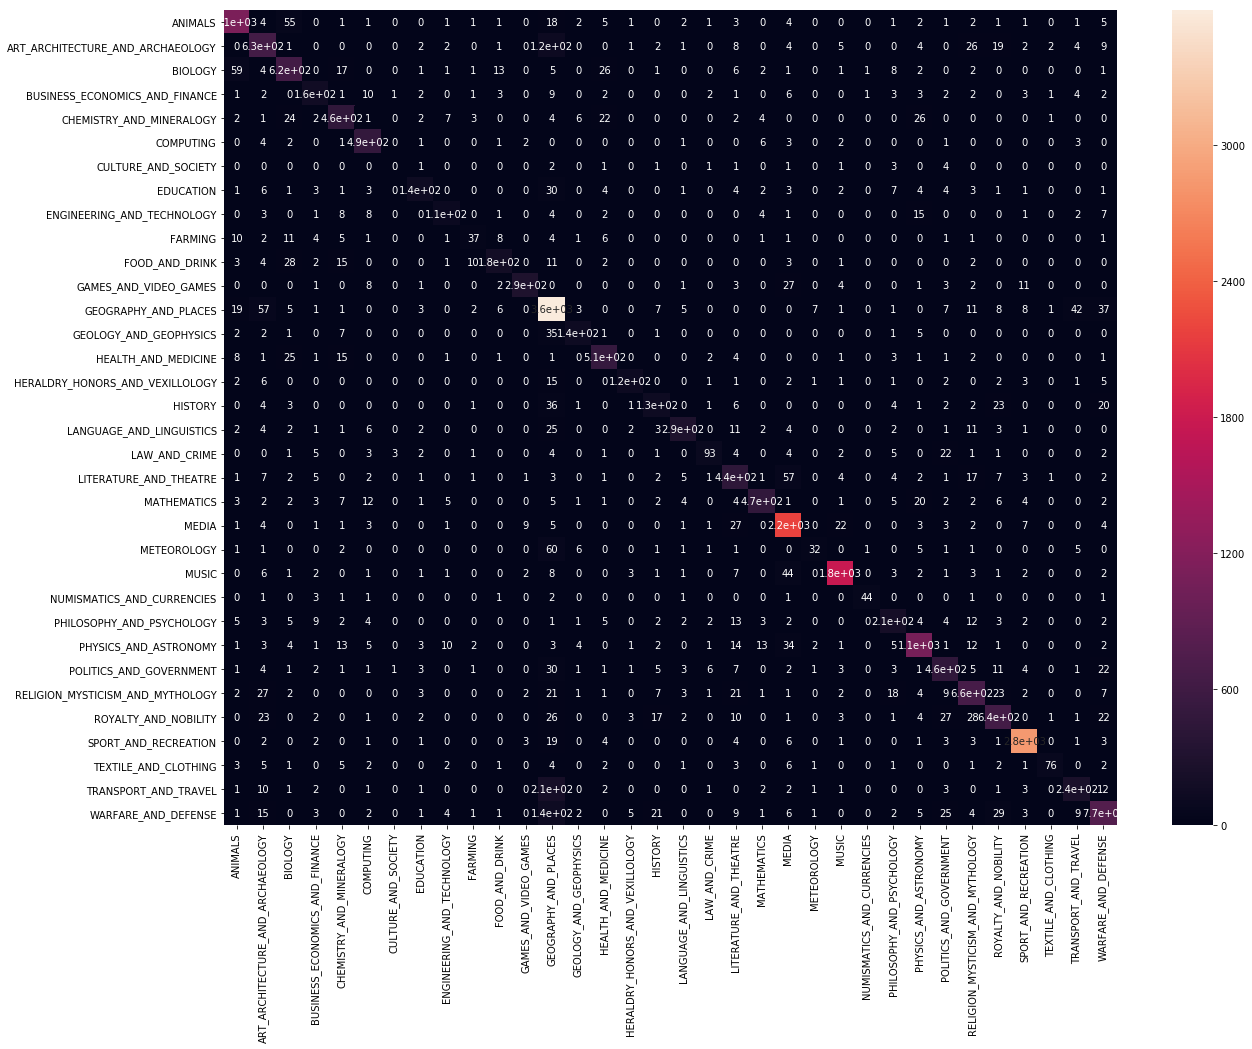

In [11]:
conf_mat = pd.DataFrame(array, 
                     index = [domain for domain in os.listdir(TRAIN_DIR)], 
                     columns = [domain for domain in os.listdir(TRAIN_DIR)])
plt.figure(figsize = (20, 15))
sn.heatmap(conf_mat, annot=True)
plt.savefig('conf_mat.png')

In [12]:
if os.path.exists(TMP_DIR + 'test.pkl'):
    # if the test dataset has already been stored in test.pkl then load it
    test = pickle.load(open(TMP_DIR + 'test.pkl', 'rb'))
else:
    # otherwise read the test dataset and store it in test.pkl
    test = read_test_data(TEST_DIR)
    pickle.dump(train, open(TMP_DIR + 'test.pkl', 'wb'))

In [13]:
test.shape

(24526, 128)

In [14]:
test_predictions = model.predict(test)

In [15]:
with open('test_answers.tsv', 'w') as f:
    for i in range(len(test_predictions)):
        f.write('test_' + str(i) + '\t' + test_predictions[i] + '\n')